In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1391


<Axes: xlabel='Time'>

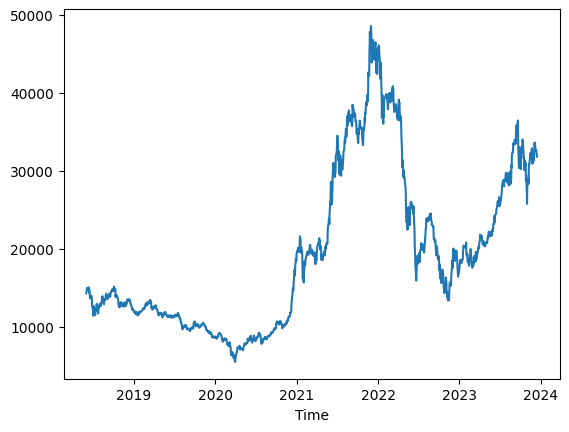

In [2]:
#2. Fetch data and visualize
# SSI
SSI = stock_historical_data(symbol = "SSI", start_date="2018-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
SSI["Close"].plot()

In [3]:
# Preprocessing
df = pd.DataFrame(SSI['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,14270
1,14730
2,14770
3,14950
4,14700
...,...
1386,32700
1387,32600
1388,32000
1389,32000


In [4]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.032676
p-value: 0.741161


In [5]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -14.877274
p-value: 0.000000


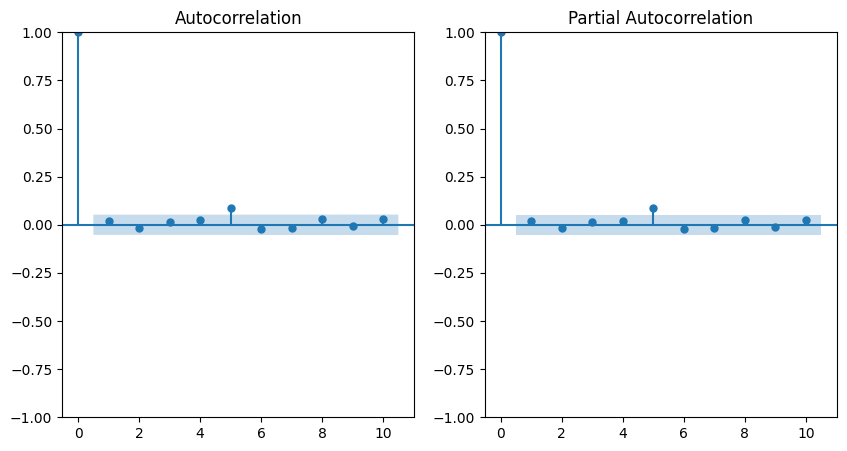

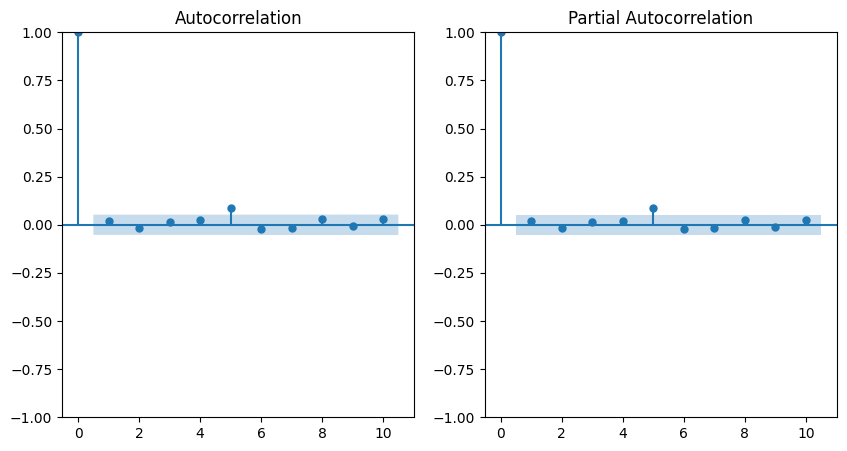

In [6]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [7]:
#3. Slit the data into train : 
# Test with ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:]

In [8]:
# adf for train set
adf = adfuller(train_data73, regression='c', maxlag=30)
print("ADF stat: %f" % adf[0])
print("p-value: %f" % adf[1])
#=> not stationary

ADF stat: -0.708129
p-value: 0.844633


In [9]:
# adf for train set diff
adf1 = adfuller(train_data73.diff().dropna(), regression='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#=> stationary

ADF stat: -5.422296
p-value: 0.000003


In [10]:
# 4. Training process
# 7 : 3 RATIO
x_train73 = np.array(train_data73.index).reshape(-1, 1)
y_train73 = np.array(train_data73['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model73 = auto_arima(y_train73, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit73 = model73.fit(y_train73)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15088.784, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15096.727, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15097.887, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15097.856, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15095.573, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15101.397, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15101.343, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15088.434, Time=0.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15103.181, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15091.985, Time=0.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15092.879, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15103.026, Time=0.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=15094.927, Time=1.14 sec
 ARIMA(3,1,2)(0,0,0)[0]  

In [11]:
# 5. Testing process
# 7:3 RATIO
x_test73 = np.array(test_data73.index).reshape(-1, 1)
y_test73 = np.array(test_data73['Close'])
y_pred73 = model73.predict(n_periods=len(y_test73))

In [12]:
# 6. 60 days prediction
# 7:3 RATIO
last_index73 =  df.index[-1]
last_data73 =pd.RangeIndex(start=last_index73, stop=last_index73 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days73 = np.array(range(last_index73 + 1, last_index73 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days73 = model73.predict(len(x_next_60_days73))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days73)

Predicted prices for the next 60 days: 
[30805.50181187 30801.98987458 30613.89111088 30598.29267091
 30796.33559283 30863.46249739 30695.92404346 30614.44259322
 30780.13104682 30906.28826219 30781.47718275 30649.62456961
 30763.94540934 30930.3511349  30863.57106282 30702.67316503
 30754.44700058 30938.02307297 30936.06540954 30770.1235727
 30757.05502083 30933.71425015 30994.42538513 30846.79561811
 30775.29109381 30923.17829578 31036.23359144 30926.57270831
 30810.41724963 30912.67783555 31061.39401553 31003.26204004
 30861.39256567 30908.12834137 31072.01778833 31071.41784877
 30925.13677503 30914.33471394 31072.02326588 31127.02083419
 30997.04919077 30934.41649915 31066.51894941 31167.93176348
 31071.70034993 30969.48744643 31061.06273651 31194.07160599
 31143.59545318 31018.6178833  31060.90223988 31207.31932801
 31207.90469883 31079.06941754 31070.29768712 31211.15630504
 31261.06572521 31146.75603273 31092.01244144 31210.11823839]


In [14]:
# 7:3 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred73 - y_test73)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test73 - y_pred73) / y_test73)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred73 - y_test73))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred73, y_test73))

Testing RMSE: 10331.528590554208
Testing MAPE: 46.071065419449226
Testing MAE: 9097.69181553616
Testing MSLR:  0.1733426964077105


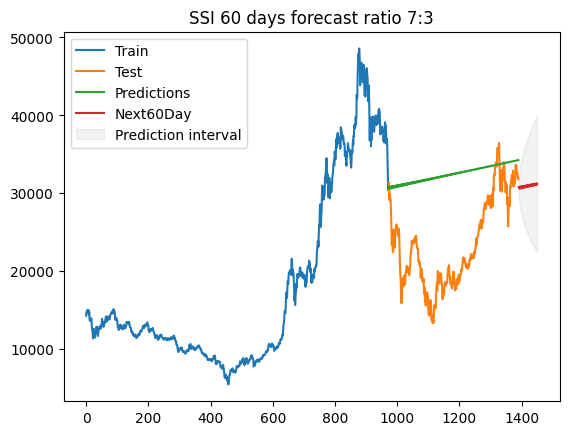

In [28]:
# 7:3 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit73.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data73.index, train_data73['Close'])
plt.plot(test_data73.index, test_data73['Close'])
plt.plot(test_data73.index, y_pred73)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 7:3")
plt.show()